# Classical Random Circuits

Here we use classical circuits to get a handle on error rates.

## setup

In [14]:
import random
import itertools
import networkx as nx
import numpy as np
import pandas as pd
import time

from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer
from pyquil.gates import CNOT, CCNOT, X, I, H, CZ, MEASURE, RESET
from pyquil.quilbase import Pragma
from scipy.spatial.distance import hamming
import scipy.interpolate
#from forest_benchmarking.compilation import basic_compile

from forest_benchmarking.classical_random_circuits import *

## graph state measurement and plotting functions

In [2]:
#qc_perfect = get_qc("Aspen-1-15Q-A", as_qvm=True, noisy=False)
#qc_noisy = get_qc("Aspen-1-15Q-A", as_qvm=True, noisy=True)

qc_perfect = get_qc("9q-square-qvm", as_qvm=True, noisy=False)
qc_noisy = get_qc("9q-square-qvm", as_qvm=True, noisy=True)

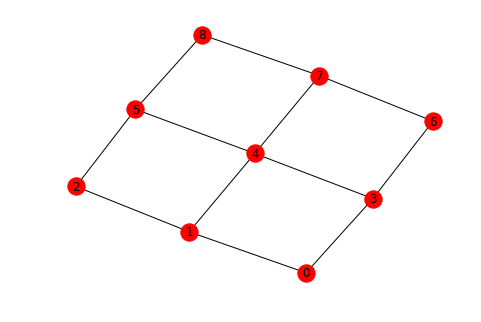

In [3]:
nx.draw(qc_perfect.qubit_topology(),with_labels=True)

In [4]:
#from pyquil import *
#list_quantum_computers()

In [5]:
G = qc_perfect.qubit_topology()
len(qc_perfect.qubit_topology())
# distribution of graph lengths
disty = []
for gdx in range(1,len(G.nodes)+1):
    listg = generate_connected_subgraphs(G,gdx)
    disty.append(len(listg))

disty

[9, 12, 22, 36, 49, 48, 32, 9, 1]

In [6]:
G = qc_perfect.qubit_topology()

In [15]:
# with these parameters the cell below takes about 2 minutes
num_shots_per_circuit = 40
num_rand_subgraphs = 4
num_rand_circuits_per_subgraph = 3
depth = 7
widthy = 5 #max = len(G.nodes)
in_x_basis = False

In [16]:
#t0 = time.time()

data = []
# loop over different graph sizes
for depth_idx,subgraph_size in itertools.product(range(1,depth+1), range(1,widthy+1)):
    list_of_graphs = generate_connected_subgraphs(G, subgraph_size)
    wt = []
    for kdx in range(1, num_rand_subgraphs+1):
        # randomly choose a lattice from list
        lattice = random.choice(list_of_graphs)
        for jdx in range(1, num_rand_circuits_per_subgraph+1):
            prog = generate_random_classial_circuit_with_depth(lattice, depth_idx, in_x_basis)
            # perfect 
            perfect_bitstring = qc_perfect.run_and_measure(prog, trials=1)
            perfect_bitstring_array = np.vstack(perfect_bitstring[q] for q in prog.get_qubits()).T
            # run on hardware or noisy QVM
            actual_bitstring = qc_noisy.run_and_measure(prog, trials=3)
            actual_bitstring_array = np.vstack(actual_bitstring[q] for q in prog.get_qubits()).T
            wt.append(get_error_hamming_distance_from_results(perfect_bitstring_array, actual_bitstring_array))

    # for each graph size flatten the results        
    wt_flat = [item for sublist in wt for item in sublist]
    hamming_wt_distr = get_error_hamming_distributions_from_list(wt_flat, subgraph_size)
    # list of dicts. The keys are (depth, width, hamming_dist)
    data.append({'depth': depth_idx, 'width': subgraph_size, 'hamming_dist': hamming_wt_distr})

#t1 = time.time()
#total = t1-t0

In [22]:
df = pd.DataFrame(data)
df

,depth,hamming_dist,width
0,1,"[0.8333333333333334, 0.0]",1
1,1,"[0.8611111111111112, 0.1388888888888889, 0.0]",2
2,1,"[0.8611111111111112, 0.1388888888888889, 0.0, ...",3
3,1,"[0.7777777777777778, 0.2222222222222222, 0.0, ...",4
4,1,"[0.6666666666666666, 0.3055555555555556, 0.027...",5
5,2,"[0.9444444444444444, 0.0]",1
6,2,"[0.8055555555555556, 0.19444444444444445, 0.0]",2
7,2,"[0.8055555555555556, 0.1388888888888889, 0.055...",3
8,2,"[0.8055555555555556, 0.19444444444444445, 0.0,...",4
9,2,"[0.7222222222222222, 0.2222222222222222, 0.055...",5


In [23]:
def get_hamming_dist(df: pd.DataFrame, depth_val: int, width_val: int):
    idx = df.depth== depth_val
    jdx = df.width== width_val
    return df[idx&jdx].reset_index(drop=True)

def get_hamming_dists_fn_width(df: pd.DataFrame, depth_val: int):
    idx = df.depth== depth_val
    return df[idx].reset_index(drop=True)

def get_hamming_dists_fn_depth(df: pd.DataFrame, width_val: int):
    jdx = df.width== width_val
    return df[jdx].reset_index(drop=True)

# Plot a particular depth and width

In [24]:
dep = 2
wid = 2
distz = get_hamming_dist(df, dep, wid)

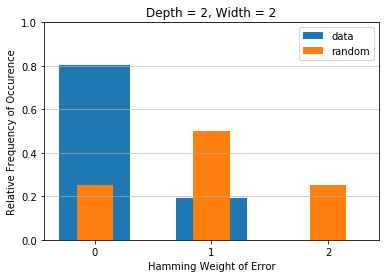

In [25]:

averaged_distr = distz['hamming_dist'][0]

rand_ans_distr = hamming_dist_rand(wid,0)

x_labels = np.arange(0, len(averaged_distr))
plt.bar(x_labels, averaged_distr, width=0.61, align='center')
plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurence')
plt.ylim([0,1])
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.show()

# For a particular width plot all depths

In [26]:
wid = 4
hdis = get_hamming_dists_fn_depth(df, wid)

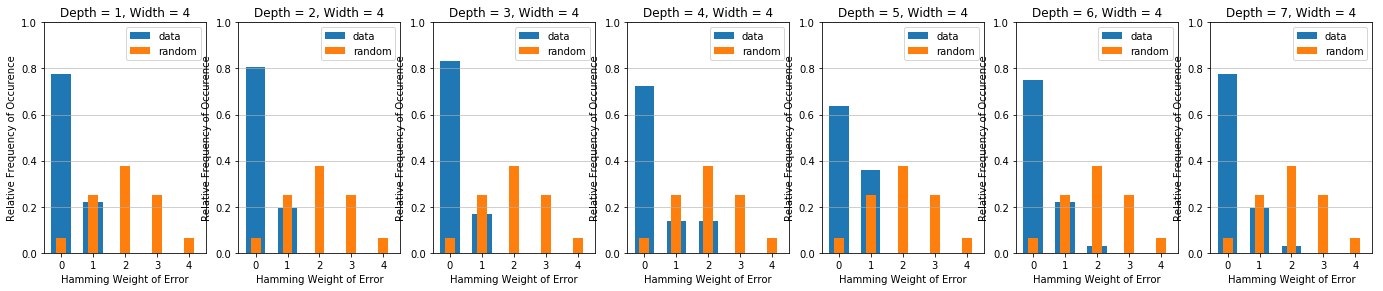

In [27]:
for hdx in range(0, len(hdis)):
    averaged_distr = hdis.iloc[hdx]['hamming_dist']
    dep = hdis.iloc[hdx]['depth']
    rand_ans_distr = hamming_dist_rand(wid,0)
    x_labels = np.arange(0, len(averaged_distr))
    plt.subplot(1,len(hdis),hdx+1)
    plt.bar(x_labels, averaged_distr, width=0.61, align='center')
    plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
    plt.xticks(x_labels)
    plt.xlabel('Hamming Weight of Error')
    plt.ylabel('Relative Frequency of Occurence')
    plt.ylim([0,1])
    plt.grid(axis='y', alpha=0.75)
    plt.legend(['data','random'])
    plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.subplots_adjust(bottom=0.1, right=3.2, top=0.9)
plt.show()

Now we can study the sucess probablity, i.e. the zero hamming weight entry above as a function of depth. We first need to extract the data fron the data frame.

In [28]:
def basement_function(number: float):
    '''
    Once you are in the basement you can't go lower.
                                /
                                | 0,    if number <= 0
    basement_function(number) = |
                                | floor(number), if number > 0
                                \
    :param number: the basement function is applied to this number.
    :returns: basement of the number
    '''
    if number <= 0.0:
        basement_of_number = 0.0
    else:
        basement_of_number = np.floor(number)
    return basement_of_number

In [29]:
num_bit_flips_allowed_from_answer = int(basement_function(np.log2(wid)-1))

pcheck = []
pcheck_rand = []
depth_vec = []
pcheck_log_errors = []
rand_pcheck_log_errors = []

for hdx in range(0, len(hdis)):
    averaged_distr = hdis.iloc[hdx]['hamming_dist']
    # probablity of getting the correct answer
    pcheck.append(averaged_distr[0])
    rand_ans_distr = hamming_dist_rand(wid,0)
    # probablity of getting the correct by randomly guessing
    pcheck_rand.append(rand_ans_distr[0])
    # error when you allow for a logarithmic number of bit flips from the true answer
    pcheck_log_errors.append(sum([averaged_distr[idx] for idx in range(0,num_bit_flips_allowed_from_answer+1)]))
    rand_pcheck_log_errors.append(sum([rand_ans_distr[idx] for idx in range(0,num_bit_flips_allowed_from_answer+1)]))
    dep = hdis.iloc[hdx]['depth']
    depth_vec.append(dep)

Next we will plot the sucess probablity of a circuit with a certain width as a function of depth. 

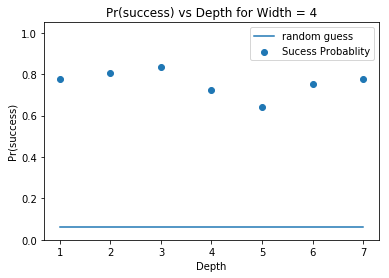

In [30]:
plt.scatter(depth_vec,pcheck,label='Sucess Probablity')
plt.plot(depth_vec,pcheck_rand,label='random guess')
plt.ylim([0,1.05])
plt.xlabel('Depth')
plt.ylabel('Pr(success)')
plt.title('Pr(success) vs Depth for Width = {}'.format(wid))
plt.legend()
plt.show()

Now we allow a logarithmic number of bits to flip from the correct answer and call all such instances "success". E.g.

The logarithmic number of bits that we allow to flip is defined by the "basement" of 

$\log_2 ({\rm number\ of\ bits}) -1$

where the basement of a number is ${\rm basement(number)} = 0$ if number$<=0$ and ${\rm basement(number)} = {\rm floor (number)}$.


Supose we have a circuit of width 4, this means correct string has four bits, e.g. 1010. Then a logarithmic number of flips is $\log_2(4)-1 = 1$.

So any string with hamming weight zero or one counts as a success.

Such error metrics might be important in noisy near term algorithms where getting the exact answer is not vital.

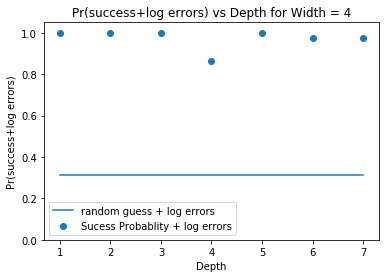

In [31]:
plt.figure()
plt.scatter(depth_vec,pcheck_log_errors,label='Sucess Probablity + log errors')
plt.plot(depth_vec,rand_pcheck_log_errors,label='random guess + log errors')
plt.ylim([0,1.05])
plt.xlabel('Depth')
plt.ylabel('Pr(success+log errors)')
plt.title('Pr(success+log errors) vs Depth for Width = {}'.format(wid))
plt.legend()
plt.show()

# Plot depth = width

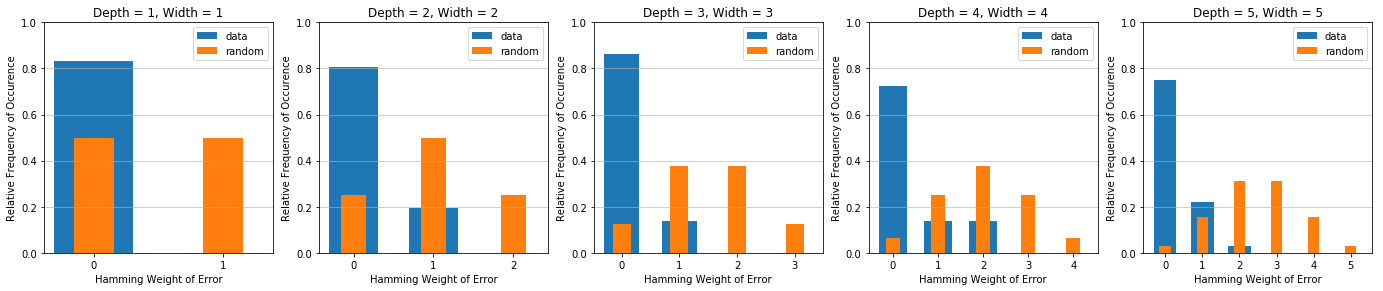

In [32]:
max_idx = min([max(df['depth']),max(df['width'])])

for idx in range(1,max_idx+1):
    hdis = get_hamming_dist(df, idx, idx)
    averaged_distr = hdis['hamming_dist'][0]
    dep = hdis['depth'][0]
    wid = hdis['width'][0]
    rand_ans_distr = hamming_dist_rand(idx,0)
    x_labels = np.arange(0, len(averaged_distr))
    plt.subplot(1,max_idx,idx)
    plt.bar(x_labels, averaged_distr, width=0.61, align='center')
    plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
    plt.xticks(x_labels)
    plt.xlabel('Hamming Weight of Error')
    plt.ylabel('Relative Frequency of Occurence')
    plt.ylim([0,1])
    plt.grid(axis='y', alpha=0.75)
    plt.legend(['data','random'])
    plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.subplots_adjust(bottom=0.1, right=3.2, top=0.9)
plt.show()

# Plot success probablity landscape

In [33]:
def interpolate_2d_landscape(points, values, resolution=200, interp_method='nearest'):
    """
    Convenience function for interpolating a list of points and corresponding list of values
    onto a 2D meshgrid suitable for plotting.

    See :py:func:`plot_2d_landscape`.

    :param points: A numpy array where the first column is x values and the second column
        is y values
    :param values: The value at each point (z)
    :param resolution: The number of points per side in the interpolated meshgrid
    :param interp_method: The scheme used for interpolation. "cubic" or "linear" will give
        you a prettier picture but "nearest" will prevent you from overconfidence.
    :return: meshgrid arrays (xx, yy, zz) suitable for plotting.
    """
    xx, yy = np.meshgrid(
        np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), resolution),
        np.linspace(np.min(points[:, 1]), np.max(points[:, 1]), resolution),
    )
    zz = scipy.interpolate.griddata(points, values, (xx, yy), method=interp_method)
    return xx, yy, zz

In [34]:
points = np.vstack((df['depth'].values, df['width'].values)).T
points.shape

(35, 2)

In [35]:
# df['hamming_dist'][0] returns the array
# df['hamming_dist'][0][0] returns the first element of the array
values = np.asarray([df['hamming_dist'][idx][0] for idx in df.index])
values

array([0.83333333, 0.86111111, 0.86111111, 0.77777778, 0.66666667,
       0.94444444, 0.80555556, 0.80555556, 0.80555556, 0.72222222,
       0.88888889, 0.94444444, 0.86111111, 0.83333333, 0.69444444,
       0.97222222, 0.80555556, 0.83333333, 0.72222222, 0.66666667,
       1.        , 0.88888889, 0.83333333, 0.63888889, 0.75      ,
       0.86111111, 0.91666667, 0.80555556, 0.75      , 0.66666667,
       0.94444444, 0.83333333, 0.75      , 0.77777778, 0.72222222])

In [36]:
rand_width = [hamming_dist_rand(idx, 0)[0] for idx in range(1,widthy+1)]
rand_width

values_rand = np.asarray([item for sublist in [rand_width for ddx in range(1,depth+1)] for item in sublist])

#values_rand = np.vstack((rand_width, rand_width, rand_width)).T
values_rand.shape

(35,)

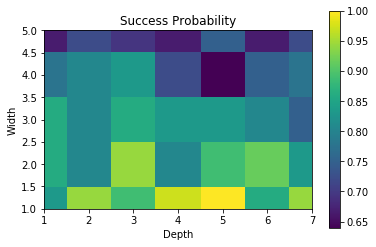

In [37]:
xx, yy, zz = interpolate_2d_landscape(points, values)

ax = plt.gca()
img = ax.imshow(zz, interpolation='none',
                extent=(xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]),
                cmap='viridis', origin='lowerleft', norm=plt.Normalize(None, None))
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability')
plt.show()

(35, 2)


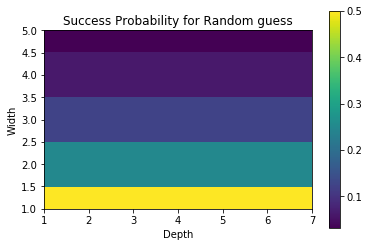

In [38]:
print(points.shape)
xx, yy, zz = interpolate_2d_landscape(points, values_rand)

ax = plt.gca()
img = ax.imshow(zz, interpolation='none',
                extent=(xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]),
                cmap='viridis', origin='lowerleft', norm=plt.Normalize(None, None))
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability for Random guess')
plt.show()